In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt

from KF_parametric_autograd import GPRegressor
from sklearn.metrics import mean_squared_error as mse

# The regression problem


Suppose we have noisy observations of an unknwon function

$$ y_i = f(x_i) + \varepsilon_i$$
wehere $\varepsilon_i$ is i.i.d noise. We wish to recover the underlying function $f$. 

In Kernel Methods and Gaussian processes regression, the solution to the above problem has the representer representation

$$ f^* = k(\cdot, X)(K(X,X) + \lambda I)^{-1}Y$$

where $X = (x_i)_{i=1}, Y = (y_i)_{i=1}$ are the vectors of observations and $k$ is a kernel function parametrized by some parameters $\theta$.

# Choosing the best kernel

The above solution relies on a choice of kernel family $k$ and a choice of parameters $\theta$. Here we focus on the problem of given a kernel family, choose the optimal parameter $\theta$.

The paper "Kernel Flows: from learning kernels from data into the abyss" by Owhadi and Yoo (https://arxiv.org/abs/1808.04475) proposes to minimize a cross validation loss by sampling a subset $(X_s, Y_s)$ from the full data set $(X, Y)$ (of roughly half the size). We then minimize the following (random) loss

$$ \rho(\theta) = \frac{|| u - u_s||^2}{|| u||^2 } = 1 - \frac{Y_s^T K(X_s,X_s)^{-1}Y^s}{Y^T K(X,X)^{-1}Y}.$$

The function $ u$ is the optimal function which sees the full data set $(X,Y)$ and $u_s$ is the optimal function which sees the sample $(X_s, Y_s)$. The norm is the RKHS induced by the kernel. For more details, see the following talk https://www.youtube.com/watch?v=ZndevdR4omw.

# Implementation

## Data set 

In [70]:
# A relatively complicated 2d function

def f(x):
    return np.sin(5 * x[1]) * (1 - np.tanh(x[0] ** 2)) + x[0]**3*np.exp(-x[1])

In [71]:
np.random.seed(2019)
x = np.random.uniform(-2, 2, size = (100,2))

noise_level = 0.5
np.random.seed(2020)
noise = np.random.normal(size = (100))*noise_level

fx = np.array([f(x_i) for x_i in x])
y = np.array([f(x_i)+ noise[i] for i, x_i in enumerate(x)])

In [72]:
from sklearn.model_selection import train_test_split

X, X_test, Y, Y_test = train_test_split(x,y, test_size = 0.2, random_state=2022, shuffle = True) 

## Default GP regressor

In [73]:
# Import the RBF kernel
from kernel_functions_autograd import kernel_RBF

In [77]:
sigma = np.array([2.0])
GP =  GPRegressor(kernel_RBF, sigma)

GP.fit(X,Y)

pred = GP.predict(X_test)

print("The mean squared error on the test set is", np.round(mse(pred, Y_test), 3))

The mean squared error on the test set is 26.163


# Kernel Optimized via Bayesian optimization

Here we present an an alternative to gradien descent based on Bayesian optimization. This algorithm does not need to compute derivative and is less prone to local minima. Hence in some cases it can be more efficient than gradient descent. A potential danger is that sometimes minimizing the loss can yield degenerate kernels. 

In [78]:
from skopt import gp_minimize

from sklearn.model_selection import KFold

In [79]:
# Define the objective function to be minimzed 

def objective(parameters):
    return GP.rho_average(parameters, X, Y, n = 5)

# Define a search space 
from skopt.space import Real
space  = [Real(10**-5, 10**1, name='sigma')]

# Define the GP (here the initial choice of paramters is less important)
sigma = np.array([1.0])
GP =  GPRegressor(kernel_RBF, sigma)

In [80]:
res = gp_minimize(objective,                  # the function to minimize
                  space,      # the search space
                  acq_func="EI",      # the acquisition function
                  n_calls=100,         # the number of evaluations of f
                  n_random_starts=10,  # the number of random initialization points
                  random_state=1234,  # the random seed
                  verbose = False,    # set to True for longer runs
                 )   

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


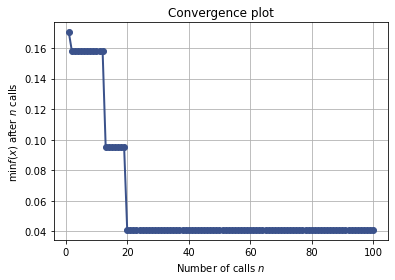

In [81]:
from skopt.plots import plot_convergence
plot_convergence(res);

In [82]:
opt_param = res.x
objective(opt_param)

0.14797848831016683

In [83]:
opt_param = res.x

GP.fit(X, Y, parameters=opt_param)

pred = GP.predict(X_test)
print("The optimized parameters are ", GP.parameters)
print("The mean squared error on the test set is", np.round(mse(pred, Y_test), 3))

The optimized parameters are  [7.21959588]
The mean squared error on the test set is 16.127
